Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

Mount the drvie to colab

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Importing all the important libraries

In [5]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
from glob import glob

import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import load_img

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [6]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer'
data_dir_train = pathlib.Path(root_path + '/Train')   #path to train dataset
data_dir_test = pathlib.Path(root_path + '/Test')   #path to test dataset

In [7]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Load using keras.preprocessing
Let's load these images off disk using the helpful image_dataset_from_directory utility.

Create a dataset

Define some parameters for the loader:

In [8]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [9]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

## tf.keras.preprocessing.image_dataset_from_directory(): This function is used to create a tf.data.Dataset from image files in a directory.
##It automatically labels the images based on the subdirectories' names.
#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Check all the class names assigned

In [10]:
# Access the class names
class_names = train_ds.class_names

# Print the class names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [11]:
#Delete the output folder ( created after data augementation ) - This is required in case we need to re-run the notebook
for c in class_names:
  for f in glob(str( data_dir_train ) + '/'+c+ "/output/*.jpg"):
    os.remove(f)

In [12]:

## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  label_mode='categorical',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
## Write your test dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  label_mode='categorical',
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [14]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Visualize the data


Create a code to visualize one instance of all the nine classes present in the dataset

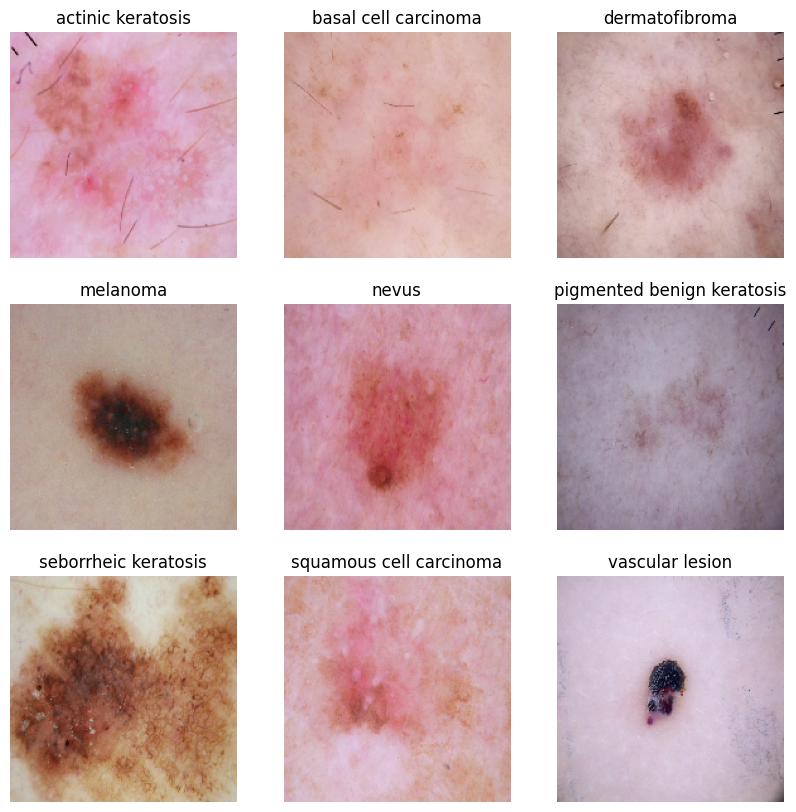

In [15]:
plt.figure(figsize=(10,10))
index = 0
for c in class_names:
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(str(data_dir_train)+'/'+c+'/'+os.listdir(str(data_dir_train)+'/'+c)[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.


In [16]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [17]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]
## Expected input shape is (180, 180, 3), indicating an image height and width of 180 pixels with 3 color channels (RGB).
## This preprocessing step is commonly used to ensure that the pixel values are in a suitable range for neural network training.

In [18]:
### Your code goes here

input_shape = (180,180,3)
lr = 1e-5        #Define small learning rate , this is hyperparameter that controls the step size at which the optimizer adjusts the weights during training.
init = 'normal'  # init represents the weight initialization method for the neural network. 'normal' refers to the normal distribution initializer, which randomly initializes the weights from a Gaussian distribution with zero mean and a specified standard deviation.
activ = 'relu'

#Sequential allows you to create models layer-by-layer
model = Sequential()
#Rescaling Layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

#Second Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Third Convulation layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

model.add(Dense(128, activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 89, 89, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 87, 87, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 43, 43, 64)       0         
 pper)                                                  

Compile the model :
Choose an appropirate optimiser and loss function for model training

In [19]:
### Todo, choose an appropirate optimiser and loss function

#Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
#categorical_crossentropy is used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrapp  (None, 178, 178, 32)     896       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 89, 89, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 87, 87, 64)       18496     
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 43, 43, 64)       0         
 pper)                                                  

### Train the model

In [21]:
epochs = 20
batch_size = 32

#Train the model
history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 506s 2s/step - loss: 1.8905 - accuracy: 0.3198 - val_loss: 1.5937 - val_accuracy: 0.4832
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 1.5157 - accuracy: 0.4849 - val_loss: 1.4769 - val_accuracy: 0.5011
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.3718 - accuracy: 0.5206 - val_loss: 1.7878 - val_accuracy: 0.4407
Epoch 4/20
56/56 [==============================] - 2s 31ms/step - loss: 1.3267 - accuracy: 0.5352 - val_loss: 1.3899 - val_accuracy: 0.5414
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.2423 - accuracy: 0.5586 - val_loss: 1.4940 - val_accuracy: 0.4676
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.1831 - accuracy: 0.5915 - val_loss: 1.4960 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 2s 33ms/step - loss: 1.1076 - accuracy: 0.5943 - val_loss: 1.4441 - val_accuracy: 0.5168
Epoch 8/20
56

Visualizing training results

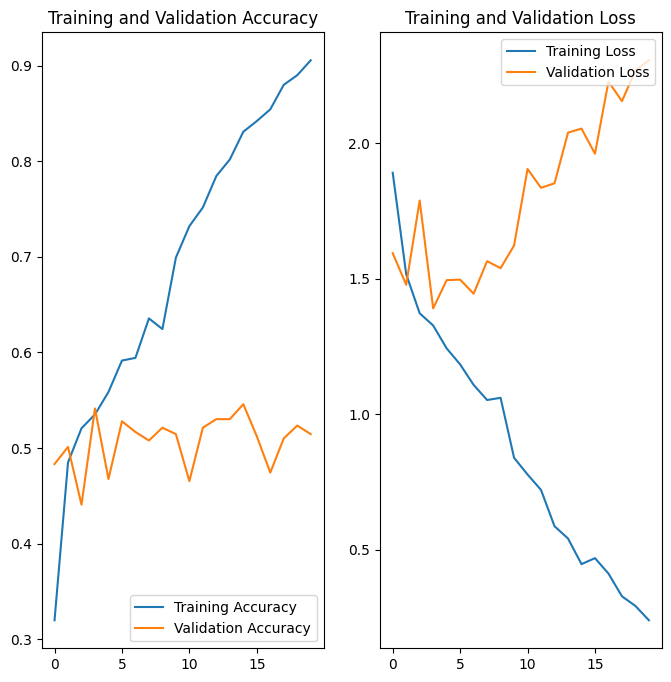

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 12ms/step - loss: 2.3055 - accuracy: 0.5145
Accuracy:  0.9313616156578064
Validation Accuracy:  0.5145413875579834
Loss:  0.19404439628124237
Validation Loss 2.3055272102355957


Model Overfit or Underfit?

It's worth noting that the validation accuracy is significantly lower than the training accuracy, and the validation loss is higher than desired. This discrepancy could indicate overfitting, where the model performs well on the training data but struggles to generalize to new, unseen data.

## Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.

Data augmentation is a commonly used technique in Convolutional Neural Networks (CNNs) to artificially increase the size of the training dataset by applying various transformations to the existing images.
These augmentation techniques can be implemented using libraries like TensorFlow's ImageDataGenerator or OpenCV. By applying these transformations to the training images during each epoch, the model sees different variations of the same data, helping it learn more robust and invariant features.

In [24]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


train_batches = datagen.flow_from_directory(data_dir_train,
    target_size = (180,180),
    classes = class_names,
    batch_size = 32
 )

valid_batches = datagen.flow_from_directory(data_dir_test,
    target_size = (180,180),
    classes = class_names,
    batch_size = 32
)

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


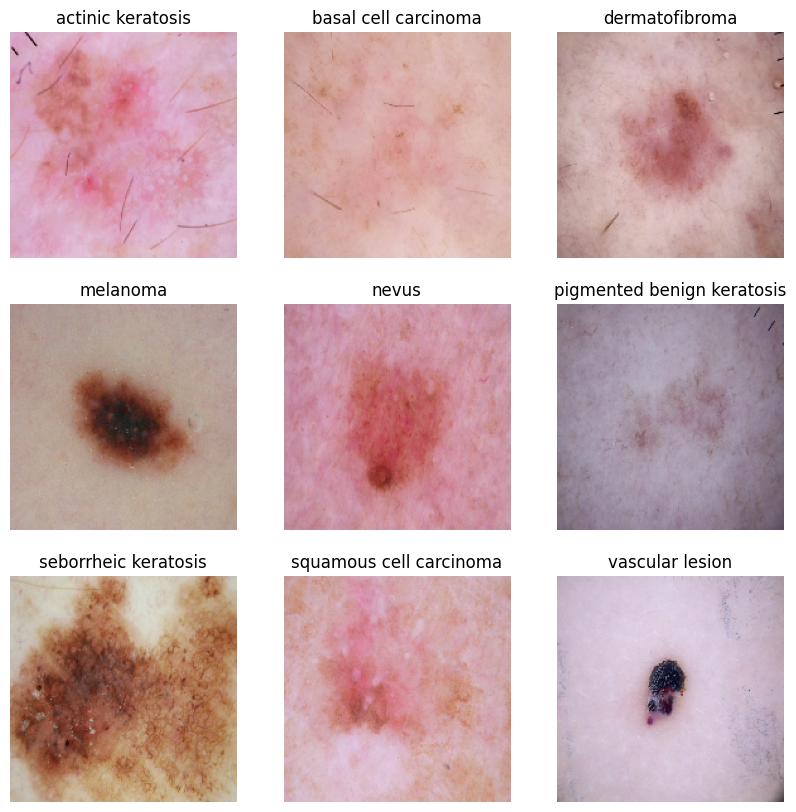

In [25]:
# Visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,10))

index = 0
for c in class_names:
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(str(data_dir_train)+'/'+c+'/'+os.listdir(str(data_dir_train)+'/'+c)[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")


Create the model, compile and train the model

In [26]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

### Your code goes here

input_shape = (180,180,3)
lr = 1e-5        #Define small learning rate , this is hyperparameter that controls the step size at which the optimizer adjusts the weights during training.
init = 'normal'  # init represents the weight initialization method for the neural network. 'normal' refers to the normal distribution initializer, which randomly initializes the weights from a Gaussian distribution with zero mean and a specified standard deviation.
activ = 'relu'

#Sequential allows you to create models layer-by-layer
model = Sequential()
#Rescaling Layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer before passing to second layer
model.add(Dropout(0.25))

#Second Convulation layer
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer before passing to third layer
model.add(Dropout(0.25))

#Third Convulation layer
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer before passing to flatten layer
model.add(Dropout(0.25))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

## Number of classes is 9
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_8 (ModuleWra  (None, 178, 178, 32)     896       
 pper)                                                           
                                                                 
 module_wrapper_9 (ModuleWra  (None, 89, 89, 32)       0         
 pper)                                                           
                                                                 
 module_wrapper_10 (ModuleWr  (None, 89, 89, 32)       0         
 apper)                                                          
                                                                 
 module_wrapper_11 (ModuleWr  (None, 87, 87, 64)       18496     
 apper)                                               

### Compiling the model

In [27]:
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

### Training the model (After using Data augumentation strategy and Dropout in between CNN layers )

In [28]:
## Your code goes here, note: train your model for 20 epochs

epochs = 20
batch_size = 32

#Train the model
history = model.fit(
  train_batches,
  batch_size=batch_size,
  validation_data=valid_batches,
  epochs=epochs
)

Epoch 1/20
70/70 [==============================] - 161s 2s/step - loss: 2.4907 - accuracy: 0.1956 - val_loss: 2.1632 - val_accuracy: 0.1356
Epoch 2/20
70/70 [==============================] - 73s 1s/step - loss: 2.0470 - accuracy: 0.2023 - val_loss: 2.1584 - val_accuracy: 0.1356
Epoch 3/20
70/70 [==============================] - 85s 1s/step - loss: 2.0264 - accuracy: 0.2001 - val_loss: 2.1603 - val_accuracy: 0.2034
Epoch 4/20
70/70 [==============================] - 73s 1s/step - loss: 1.9418 - accuracy: 0.2845 - val_loss: 2.0652 - val_accuracy: 0.2034
Epoch 5/20
70/70 [==============================] - 85s 1s/step - loss: 1.8230 - accuracy: 0.3390 - val_loss: 2.0270 - val_accuracy: 0.2627
Epoch 6/20
70/70 [==============================] - 72s 1s/step - loss: 1.6415 - accuracy: 0.4301 - val_loss: 2.2615 - val_accuracy: 0.3475
Epoch 7/20
70/70 [==============================] - 71s 1s/step - loss: 1.5689 - accuracy: 0.4515 - val_loss: 2.0905 - val_accuracy: 0.2881
Epoch 8/20
70/70 [=

Visualizing the results

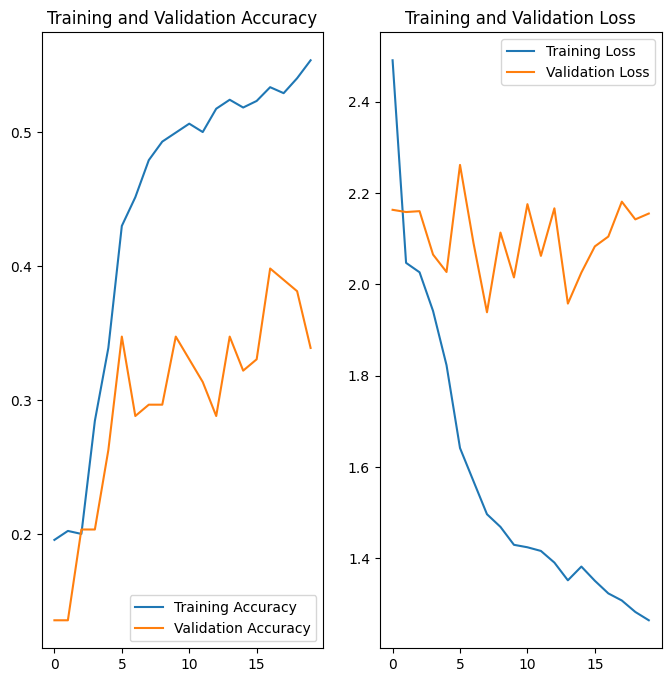

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### Answer :
We can clearly see the gap between training accuracy and validation accuracy has decreased meaning overfitting is reduced as compared to previous run. But overall accuracy has also gone down as compared to previous run.

Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

Visualize distribution of classes in the training dataset.

In [30]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #Name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,squamous cell carcinoma,181
1,basal cell carcinoma,376
2,vascular lesion,139
3,actinic keratosis,114
4,melanoma,438
5,nevus,357
6,pigmented benign keratosis,462
7,dermatofibroma,95
8,seborrheic keratosis,77


Visualize the Number of image in each class.

<Axes: xlabel='No. of Image', ylabel='Class'>

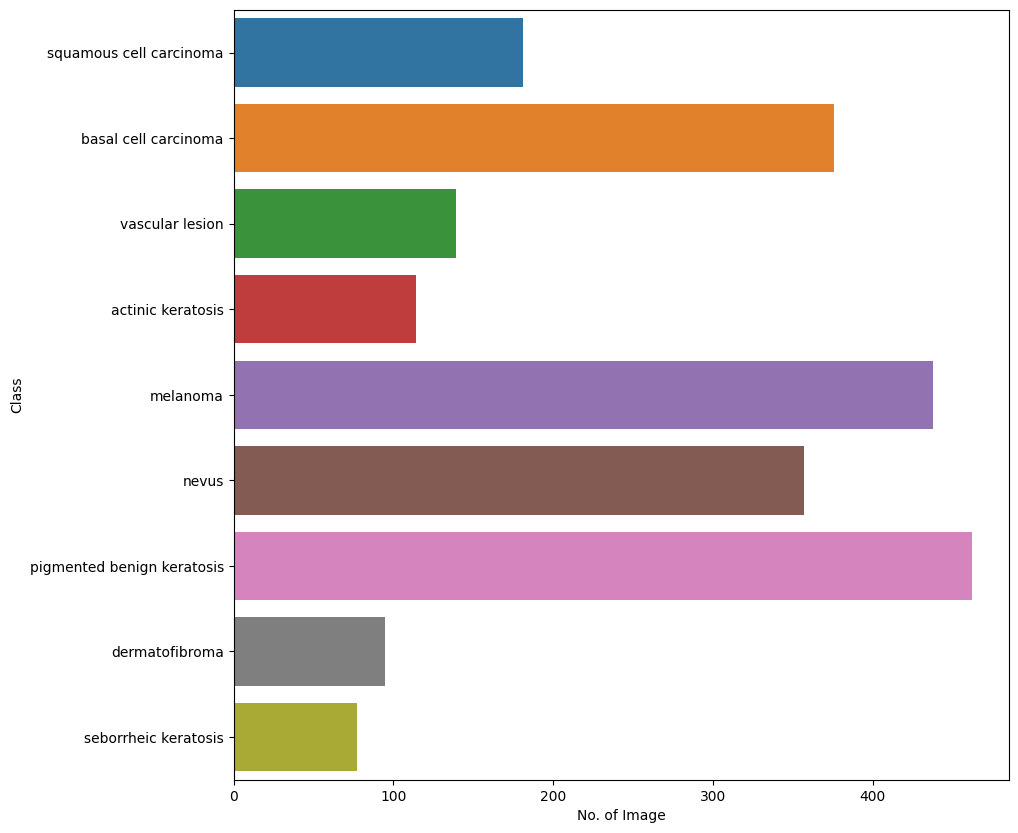

In [31]:
#Visualize the Number of image in each class after plotting graph

plt.figure(figsize=(10, 10))
sns.barplot(x="No. of Image", y="Class", data=df,label="Class")

#### **Todo:** Findings below:
#### - Which class has the least number of samples?  - 
### Answer :: 
Seborrheic keratosis and Dermatofibroma

#### - Which classes dominate the data in terms proportionate number of samples? 
### Answer ::
Pigmented benign keratosis dominates the data. There are 462 images of this category.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [32]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [33]:
path_to_training_dataset= "/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5F6CFF3D0>: 100%|██████████| 500/500 [00:24<00:00, 20.33 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5F77B1E10>: 100%|██████████| 500/500 [00:27<00:00, 18.02 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE5F76D7F40>: 100%|██████████| 500/500 [00:29<00:00, 17.22 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE5F6D5F5B0>: 100%|██████████| 500/500 [01:39<00:00,  5.01 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE60636D030>: 100%|██████████| 500/500 [01:42<00:00,  4.89 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE694059AB0>: 100%|██████████| 500/500 [00:21<00:00, 23.29 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7FE606249900>: 100%|██████████| 500/500 [00:49<00:00, 10.16 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE68161FA30>: 100%|██████████| 500/500 [00:20<00:00, 24.23 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FE606261CC0>: 100%|██████████| 500/500 [00:22<00:00, 22.27 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [34]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [35]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0026083.jpg_c4ee5bf0-6d4b-4570-96d4-19ee5af494eb.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028224.jpg_3c49a80c-b88a-4e8b-acd9-15c5dfdb68a9.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0025029.jpg_30aa4b7c-a35f-4ddb-85d8-5f231c60399b.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0029462.jpg_f558002b-67ef-4099-9eee-d1901304a893.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/squamous cell carcinoma/output/squamous cell carcinoma_original_ISIC_0028335.jpg_cd870c42-b149-4bce-a457-7f808e39a114.jpg',
 '/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Tr

In [36]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carcinoma',
 'squamous cell carc

In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [38]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [39]:
new_df['Label'].value_counts()

squamous cell carcinoma       500
basal cell carcinoma          500
vascular lesion               500
actinic keratosis             500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
dermatofibroma                500
seborrheic keratosis          500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Todo: Train the model on the data created using Augmentor

In [40]:
batch_size = 32
img_height = 180
img_width = 180

Create a training dataset

In [41]:
data_dir_train="/content/gdrive/MyDrive/Colab Notebooks/CNN/Skin_cancer/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  label_mode='categorical',
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Create a validation dataset¶

In [42]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  label_mode='categorical', # This is must to one hot encoding to categorical variable
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


Create your model (make sure to include normalization)
 - Include BatchNormalization() that will help in optimizing the training process.
 - Also inceased Dropout percentage in between CNN layers which should help in reducing overfitting further.

In [43]:
input_shape = (180,180,3)

model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))   #Rescaling Layer

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_20 (ModuleWr  (None, 180, 180, 32)     896       
 apper)                                                          
                                                                 
 module_wrapper_21 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                                          
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                                   
                                                                 
 module_wrapper_22 (ModuleWr  (None, 90, 90, 32)       0         
 apper)                                               

Compile your model (Choose optimizer and loss function appropriately)

In [44]:
#optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=['accuracy'])

Train your model

In [45]:
## Your code goes here, note: train your model for 20 epochs [As mentioned in upgrad assignment ]

epochs = 20
batch_size = 32

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    patience=3,  verbose=1,  factor=0.5, min_lr=0.00001)

history = model.fit(train_ds,epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction] )


Epoch 1/20
169/169 [==============================] - 60s 302ms/step - loss: 1.9549 - accuracy: 0.3618 - val_loss: 6.1048 - val_accuracy: 0.1151 - lr: 0.0010
Epoch 2/20
169/169 [==============================] - 39s 218ms/step - loss: 1.5399 - accuracy: 0.4586 - val_loss: 2.8771 - val_accuracy: 0.1485 - lr: 0.0010
Epoch 3/20
169/169 [==============================] - 41s 239ms/step - loss: 1.3208 - accuracy: 0.5198 - val_loss: 2.0736 - val_accuracy: 0.2658 - lr: 0.0010
Epoch 4/20
169/169 [==============================] - 40s 234ms/step - loss: 1.2178 - accuracy: 0.5575 - val_loss: 1.9325 - val_accuracy: 0.3445 - lr: 0.0010
Epoch 5/20
169/169 [==============================] - 39s 225ms/step - loss: 1.1259 - accuracy: 0.5914 - val_loss: 1.2468 - val_accuracy: 0.5286 - lr: 0.0010
Epoch 6/20
169/169 [==============================] - 38s 219ms/step - loss: 1.0846 - accuracy: 0.5961 - val_loss: 1.5650 - val_accuracy: 0.4803 - lr: 0.0010
Epoch 7/20
169/169 [==============================] 

Visualize the model results

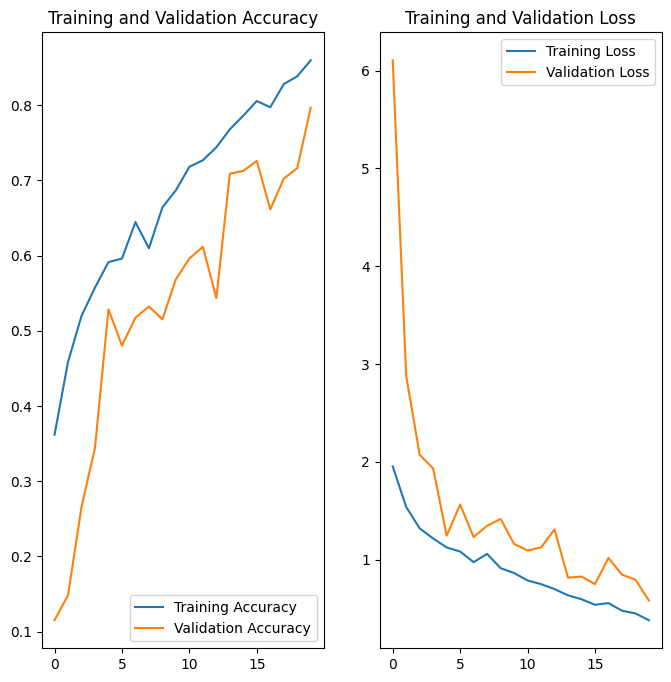

In [46]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

Definitely class rebalance significantly helped in reducing overfititng of the data as compared to previous runs.  Overall accuracy is also increased to 86% and validation accuracy increased to 80%. The gap between train and test accuracy reduced significantly.

Also in last CNN model, I used Dropout percentage from 25% to 40%-50% and also used BatchNormalization after every layer which also helped in optimizing training process and reducing overfitting.

An overall accuracy of 86% and a validation accuracy of 80% do not inherently indicate overfitting. So we can say we got rid of overfitting and this model is good for prediction.